导入库

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn import tree
import time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve,auc
from scipy import interp
import csv

处理数据

In [10]:
def load_data_feature(file):
    data = []
    with open(file,'r',encoding='utf-8') as f:
        for lines in f.readlines():
            lines = list(lines.split())
            a = []
            for line in lines:              
                a.append(float(line))
            data.append(a)
    data = np.array(data)
    return data

def load_data_label(file):
    data = []
    with open(file,'r',encoding='utf-8') as f:
        for lines in f.readlines():
            data.append(int(lines))
    data = np.array(data)
    return data

def handle_data(data):#将0-1分布处理为-1-1分布
    for i in range(len(data)):
            if data[i] == 0 :
                data[i] =-1    

调库实现决策树

In [11]:
def build_tree(xtrain,ytrain,xtest,ytest):
    clf=tree.DecisionTreeClassifier(criterion = 'gini', max_depth=1) #以信息熵为参数
    clf.fit(xtrain,ytrain) #利用数据集进行训练
    score=clf.score(xtest,ytest) #进行测试 返回预测的准确度 
    print(score)

构建基分类器

In [12]:
class TreeClassifier_weight:
    def __init__(self):
        self.best_error = 1#错误率
        self.best_feature_col = 0#选取特征列
        self.best_threshold = 0#阈值
        self.best_option = 1#根据option判断>阈值还是<阈值的标签为1

    def fit(self,x,y,sample_weight = None):
        if sample_weight is None:
            sample_weight = np.ones(len(x)) / len(x) #初始化权重矩阵
        n = x.shape[1]
        for i in range(n):
            feature = x[:, i] #特征列
            #print(feature)
            feature_sort = np.sort(np.unique(feature)) #从小到大排序
            #print(feature_sort)
            for j in range(len(feature_sort) - 1):
                threshold = (feature_sort[j] + feature_sort[j+1]) / 2 #逐一设定该特征列阈值
                for option in (0,1):
                    if option == 1:
                        y_pred = 2 * (feature >= threshold) - 1
                    else:
                        y_pred = 2 * (feature < threshold) - 1
                    #print(y_pred)
                    #print(sample_weight)
                    #print(y)
                    error = np.sum((y_pred != y) * sample_weight)
                    if error < self.best_error:
                        self.best_error = error
                        self.best_option = option 
                        self.best_feature_col = i
                        self.best_threshold = threshold
        return self
    
    def predict(self,x):
        feature = x[:,self.best_feature_col]
        if self.best_option == 1:
            pred = 2 * (feature >= self.best_threshold) - 1
        else :
            pred = 2 * (feature < self.best_threshold) - 1
        return pred
    
    def score(self,x,y,sample_weight = None):
        pred = self.predict(x)
        if sample_weight is not None:
            return np.sum((pred == y) * sample_weight)
        return np.mean((pred == y))

实现Adaboost

In [13]:
class Adaboost():
    def __init__(self,n_learners = 500):
        self.n_learners = n_learners#所有基学习器数量
        self.learners = []#存储基学习器
        self.alphas = []#存储学习率
        self.num_learner = 0#已经运行基学习器数量
    
    def fit(self,x,y,xtest,ytest):
        auc_all = []#已经训练的基学习器的auc值
        scores = []#已经训练的基学习器的准确度

        start = time.perf_counter()

        sample_weight = np.ones(len(x)) / len(x)
        for _ in range(self.n_learners):
            starti = time.perf_counter()

            ctf = TreeClassifier_weight().fit(x,y,sample_weight)
            alpha = 1/2 * np.log((1-ctf.best_error)/ctf.best_error)
            y_pred = ctf.predict(x)
            #print(y_pred)
            sample_weight *= np.exp(- alpha * y_pred * y)
            sample_weight /= np.sum(sample_weight)
            self.learners.append(ctf)
            self.alphas.append(alpha)
            self.num_learner += 1 #已经运行的基学习器数量

            #利用predict_proba获取测试集的类概率
            y_pred_ada = self.predict_proba(xtest)
            #计算fpr(假阳性率),tpr(真阳性率),thresholds(阈值)[绘制ROC曲线要用到这几个值]
            fpr,tpr,threshold=roc_curve(ytest ,y_pred_ada ,pos_label = 1)
            #计算auc
            roc_auc=auc(fpr,tpr)
            auc_all.append(roc_auc)

            #计算模型分数
            score1 = self.score_every(xtest, ytest)
            scores.append(score1)

            print("第%d个基学习器运行时间: %f s，AUC分数为：%f，准确度为：%f" % (_+1,time.perf_counter() - starti,roc_auc,score1))

        with open (file = 'BoostMain.csv',mode = 'w+',encoding='utf-8') as file:
            for i in range(self.num_learner):
                file.write(str(i+1)+','+str(auc_all[i])+',')
                #file.write(str(auc_all[i]),end=' ')
                file.write(str(scores[i]))
                file.write('\n')
        print('写入完成！')

        print("adaboost运行时间: %f s" % (time.perf_counter() - start))

        return self
    
    #预测X的类概率
    def predict_proba(self, x):
        y_pred = np.empty((len(x), self.num_learner))  
        for i in range(self.num_learner):
            y_pred[:, i] = self.learners[i].predict(x)
        y_pred = y_pred * np.array(self.alphas)  
        return np.sum(y_pred, axis=1)

    #在运行基学习器数量的基础上对于x的预测类别
    def predict_every(self, x):
        y_pred = np.empty((len(x), self.num_learner))  
        for i in range(self.num_learner):
            y_pred[:, i] = self.learners[i].predict(x)
        y_pred = y_pred * np.array(self.alphas)  
        return 2*(np.sum(y_pred, axis=1)>0)-1

    #在所有基学习器数量上对于x的预测类别
    def predict(self, x):
        y_pred = np.empty((len(x), self.n_learners))  
        for i in range(self.n_learners):
            y_pred[:, i] = self.learners[i].predict(x)
        y_pred = y_pred * np.array(self.alphas)  
        return 2*(np.sum(y_pred, axis=1)>0)-1

    #在运行基学习器数量的基础上对于模型评分
    def score_every(self, x, y):
        y_pred = self.predict_every(x)
        return np.mean(y_pred==y)

    #在所有基学习器数量上对于模型评分
    def score(self, x, y):
        y_pred = self.predict(x)
        return np.mean(y_pred==y)

画AUC曲线图

In [14]:
def plot_auc():
    #显示中文标签 
    plt.rcParams['font.sans-serif']=['SimHei'] 
    plt.rcParams['axes.unicode_minus']=False
    
    x = []
    auc_all= []
    with open (file = 'BoostMain.csv',mode = 'r+',encoding='utf-8') as file:
        lines = csv.reader(file)
        for line in lines:
            x.append(int(line[0]))
            auc_all.append(float(line[1]))
    
    x=np.array(x)
    auc_all=np.array(auc_all)
    np.round(auc_all,2)
    plt.title('AdaBoost')

    # 设置X, Y轴标题
    plt.xlabel('基学习器数量')
    plt.ylabel('AUC')
    plt.xlim(np.min(x)-10,np.max(x)+10)#确定横轴坐标范围
    plt.ylim(np.min(auc_all)-0.05,np.max(auc_all)+0.05)
    plt.plot(x,auc_all,'o',markersize =4) 
    plt.plot(x,auc_all,color='orange') 
    plt.savefig('AdaBoost.png', dpi=300)
    plt.show()    

main函数

In [15]:
def main():
    #导入数据
    xtrain_file = './adult_dataset/adult_train_feature.txt'
    ytrain_file = './adult_dataset/adult_train_label.txt'
    xtest_file = './adult_dataset/adult_test_feature.txt'
    ytest_file = './adult_dataset/adult_test_label.txt'

    #划分训练集和验证集
    xtrain = []
    ytrain = []
    xtest = []
    ytest = []
    xtrain = load_data_feature(xtrain_file)
    ytrain = load_data_label(ytrain_file)
    xtest = load_data_feature(xtest_file)
    ytest = load_data_label(ytest_file)
    handle_data(ytrain)
    handle_data(ytest)
    
    Adaboost().fit(xtrain, ytrain, xtest, ytest)
    plot_auc()

In [41]:
def plot_contractory():
    #显示中文标签 
    plt.rcParams['font.sans-serif']=['SimHei'] 
    plt.rcParams['axes.unicode_minus']=False
    
    x = []
    auc_all= []
    with open (file = 'RandomForestMain.csv',mode = 'r+',encoding='utf-8') as file:
        lines = csv.reader(file)
        for line in lines:
            x.append(int(line[0]))
            auc_all.append(float(line[1]))
    
    x=np.array(x)
    auc_all=np.array(auc_all)
    np.round(auc_all,2)

    x1 = []
    auc_all1= []
    with open (file = 'BoostMain.csv',mode = 'r+',encoding='utf-8') as file:
        lines = csv.reader(file)
        for line in lines:
            x1.append(int(line[0]))
            auc_all1.append(float(line[1]))
    
    x1=np.array(x1)
    auc_all1=np.array(auc_all1)
    np.round(auc_all1,2)
    plt.title('AdaBoost和RandomForest对比')

    # 设置X, Y轴标题
    plt.xlabel('基学习器数量')
    plt.ylabel('AUC')
    plt.xlim(np.min(x1)-10,np.max(x1)+10)#确定横轴坐标范围
    plt.ylim(np.min(auc_all1)-0.05,np.max(auc_all1)+0.05)
    plt.plot(x1,auc_all1,'o',markersize =4) 
    plt.plot(x1,auc_all1) 
    plt.plot(x,auc_all,'o',markersize=4) 
    plt.plot(x,auc_all) 
    plt.savefig('对比.png', dpi=300)
    plt.show() 

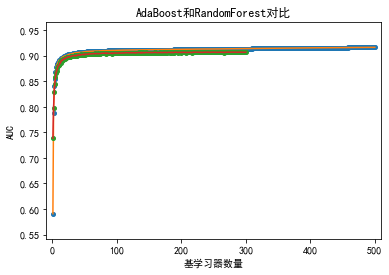

In [42]:
plot_contractory()

第1个基学习器运行时间: 6.024950 s，AUC分数为：0.590875，准确度为：0.804926
第2个基学习器运行时间: 5.937085 s，AUC分数为：0.787733，准确度为：0.804926
第3个基学习器运行时间: 5.926298 s，AUC分数为：0.840816，准确度为：0.831460
第4个基学习器运行时间: 5.960224 s，AUC分数为：0.855376，准确度为：0.835514
第5个基学习器运行时间: 6.173053 s，AUC分数为：0.868049，准确度为：0.834347
第6个基学习器运行时间: 6.154680 s，AUC分数为：0.878085，准确度为：0.836804
第7个基学习器运行时间: 6.196701 s，AUC分数为：0.882923，准确度为：0.839752
第8个基学习器运行时间: 6.149551 s，AUC分数为：0.883521，准确度为：0.830662
第9个基学习器运行时间: 6.267235 s，AUC分数为：0.887441，准确度为：0.839015
第10个基学习器运行时间: 6.449088 s，AUC分数为：0.889823，准确度为：0.833364
第11个基学习器运行时间: 6.292146 s，AUC分数为：0.891983，准确度为：0.846692
第12个基学习器运行时间: 6.204135 s，AUC分数为：0.892462，准确度为：0.834285
第13个基学习器运行时间: 6.535117 s，AUC分数为：0.893512，准确度为：0.847430
第14个基学习器运行时间: 6.322580 s，AUC分数为：0.895541，准确度为：0.845034
第15个基学习器运行时间: 6.320475 s，AUC分数为：0.896415，准确度为：0.844420
第16个基学习器运行时间: 6.394558 s，AUC分数为：0.897310，准确度为：0.845710
第17个基学习器运行时间: 6.269042 s，AUC分数为：0.898335，准确度为：0.846631
第18个基学习器运行时间: 6.357915 s，AUC分数为：0.898719，准确度为：0.842454
第19个基学习器运行时间: 6.117

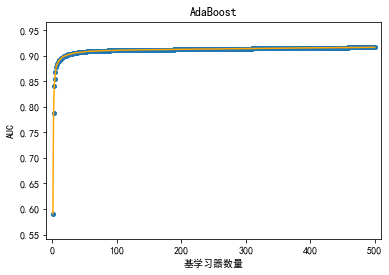

In [16]:
main()